# NTDS 2019 : Assignment 1


[Eda Bayram,](https://lts4.epfl.ch/bayram) [EPFL](http://epfl.ch) [LTS4,](http://lts4.epfl.ch)
Nikolaos Karalias, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

## Students
Team: `<your team number>`

## Rules

* The first deadline is for individual submission, the second one is for the team submission. No collaboration between teams is allowed.
* All team members will receive the same grade for the assignment regarding the solution they submit on the latter deadline.
* However, a team can is allowed to ask for individual grading, which will regard the solution submitted on the former deadline.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first and second section, the libraries to be used are given and you cannot import any other library than those. You cannot use Networkx in the first section.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

# Objective 

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

# Dataset : Cora Dataset

The [Cora dataset](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz) consists of scientific publications classified into one of seven classes. 

* **Citation graph** The citation network is constructed from the connections given in `cora.cites` file. 
* **Feature graph** Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary, given in `cora.content` file. The dictionary consists of 1433 unique words. A feature graph is contructed regarding the Euclidean distance between the feature vector of the publications.

The `README` file in the dataset provides the details about the content of the files. 

# Section 1 : Network Properties

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Question  : Construct a Citation Graph and a Feature Graph

Add path to files below. The key points of the answers in this solution work for all the communities. The specific numbers provided in some of the answers are just for the "Rule_Learning" community to provide a concrete example.

In [25]:
cd /home/aspect/LocalSolution/cora

/home/aspect/LocalSolution/cora


Q: Read the cora.content file and print out the seven different fields of study in which the papers belong to.
Print out the number of papers contained in each of those fields in the dataset.

In [26]:
table = pd.read_csv("cora.content", delimiter ="\t")
fields_of_study = table["Neural_Networks"].unique()


for field in fields_of_study:
    print("Field of study: ", field)
    print("There are {} papers in the field of ".format((table[table.Neural_Networks == field].shape[0])) + field +".")
        


Field of study:  Rule_Learning
There are 180 papers in the field of Rule_Learning.
Field of study:  Reinforcement_Learning
There are 217 papers in the field of Reinforcement_Learning.
Field of study:  Probabilistic_Methods
There are 426 papers in the field of Probabilistic_Methods.
Field of study:  Theory
There are 351 papers in the field of Theory.
Field of study:  Neural_Networks
There are 817 papers in the field of Neural_Networks.
Field of study:  Genetic_Algorithms
There are 418 papers in the field of Genetic_Algorithms.
Field of study:  Case_Based
There are 298 papers in the field of Case_Based.


Q: Select all papers from a field of your choice ("Reinforcement Learning", "Theory", etc.) and extract their feature vectors. Construct a distance matrix  $D_{ij} = d(i,j)$, where $d(i,j)$ denotes the Euclidean distance between feature vectors of papers $i$ and $j$.
Additionally, store the IDs of the selected papers in a variable as they will be required later.

In [27]:
#read table, select community, transfer to numpy
my_field = "Rule_Learning"
numpy_community = table.loc[table['Neural_Networks']==my_field].to_numpy().squeeze()

#node_ids
community_keys = numpy_community[:,0]

#keep the features
community = np.delete(numpy_community, [0,1434], axis=1).astype(float)

#compute pairwise euclidean dist matrix
one = np.ones(community.shape[0])
ker = np.matmul(community, community.T)
diagonal = np.diag(ker)
edm = np.sqrt(np.outer(diagonal, one) - 2*ker + np.outer(one,diagonal))

Q: Plot the histogram of the euclidean distances. Calculate the mean distance $ \mathbb{E}[D]$ and print out its value.



The mean euclidean distance between papers is:  5.822492039380866


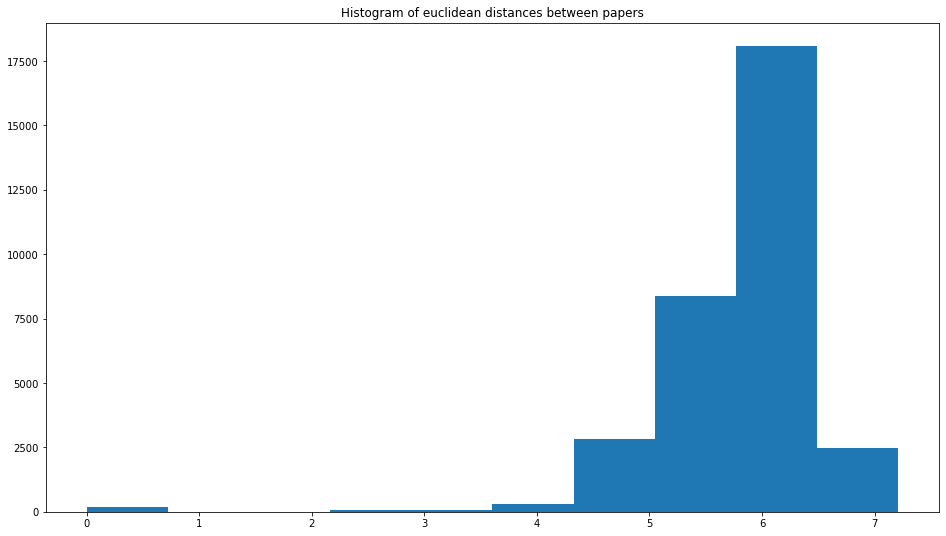

In [28]:
mean_distance = edm.mean()

print("The mean euclidean distance between papers is: ", mean_distance)

plt.figure(1, figsize=(16,9))
plt.title("Histogram of euclidean distances between papers")
plt.hist(edm.reshape(-1));

Q: Now create an adjacency matrix for the papers by thresholding the euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries: $ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j \\ 0, \; \text{otherwise.} \end{cases}$ 

In [29]:
#Thresholding the distance matrix using the mean value
thresh = edm.mean()
A_feature = (edm < thresh).astype(float) - np.eye(edm.shape[0]) # Your code here.

Q: From the cora.cites file, construct the citation graph by converting the edge index data into an adjacency matrix. 

In [30]:
cora_cites = np.genfromtxt('cora.cites', delimiter='\t')
#get graph edges and flatten them for processing
edges = cora_cites.astype(int)
edges = edges.flatten()


#get adjacency matrix from edge_list
newedge = pd.factorize(edges)[0]
new_edge_list = newedge.reshape(-1,2)
dim = max(newedge) + 1
adjmat = np.zeros((dim,dim))
adjmat[new_edge_list[:,0],new_edge_list[:,1]] = 1

#caution, matrix is not symmetric at this point 
A_citation = adjmat

Q: Get the adjacency matrix of the citation graph in the field that you chose earlier. You have to appropriately reduce the adjacency matrix of the citation graph. Symmetrize your final adjacency matrix if it's not already symmetric.

In [31]:
#map the paper ids from the selected community to the relabeled ones
nodemap = dict(zip(edges, newedge))

community_nodes = [nodemap[i] for i in community_keys]

community_adj = A_citation[community_nodes,:]
community_adj = community_adj[:,community_nodes]

#symmetrize
A_citation = community_adj + community_adj.T

### Question: Degree Distribution and Moments


Q: What is the total number of edges in each graph?

In [32]:
num_edges_feature = A_feature.sum()/2
num_edges_citation = A_citation.sum()/2
print("Number of edges in the feature graph: ", num_edges_feature)
print("Number of edges in the citation graph: ", num_edges_citation)

Number of edges in the feature graph:  5829.0
Number of edges in the citation graph:  255.0


Q: Plot the degree distribution histogram for each of the graphs.

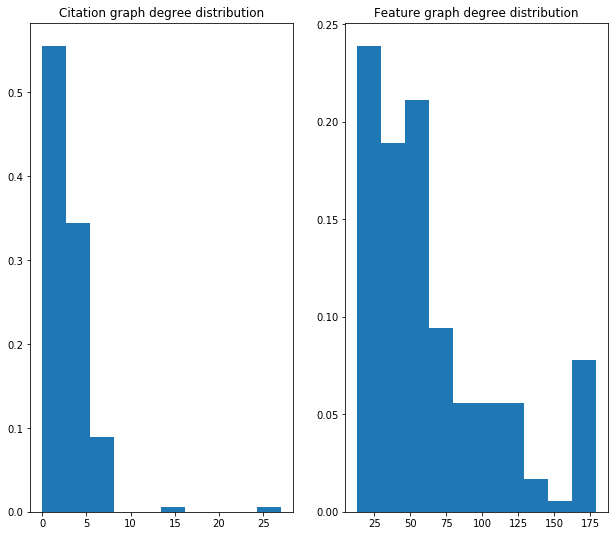

In [33]:
degrees_citation = A_citation.sum(1)
degrees_feature = A_feature.sum(1)

deg_hist_normalization = np.ones(degrees_citation.shape[0])/degrees_citation.shape[0]

plt.figure(figsize=(16,9))
plt.subplot(131)
plt.title('Citation graph degree distribution')
plt.hist(degrees_citation, weights = deg_hist_normalization);
plt.subplot(132)
plt.title('Feature graph degree distribution')
plt.hist(degrees_feature, weights = deg_hist_normalization);


Q: Calculate the first and second moments of each graph. What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

In [34]:
degfs, counts_feat = np.unique(degrees_feature,return_counts=True)
degcs, counts_cit = np.unique(degrees_citation,return_counts=True)


degfeatprobs = counts_feat/counts_feat.sum()
degcitprobs = counts_cit/counts_cit.sum()

cit_moment_1 = (degcs*degcitprobs).sum()
cit_moment_2 = (degcs*degcs*degcitprobs).sum()

feat_moment_1 = (degfs*degfeatprobs).sum()
feat_moment_2 = (degfs*degfs*degfeatprobs).sum()

print("1st moment of citation graph: ", (cit_moment_1))
print("2nd moment of citation graph: ", (cit_moment_2))
print("1st moment of feature graph: ", (feat_moment_1))
print("2nd moment of feature graph: ", (feat_moment_2))


1st moment of citation graph:  2.8333333333333335
2nd moment of citation graph:  15.455555555555556
1st moment of feature graph:  64.76666666666667
2nd moment of feature graph:  6183.166666666666


**Your answer here:** 
The first moment of the graph gives us the average degree.
The second moment gives us the variance of the degree distribution.

The citation graph is significantly sparser (recall the number of edges from the previous step). This leads to a sharp spike at low/zero degree nodes and therefore explains the value of the first moment for that graph compared to the second.

For the feature graph we observe from the degree histogram that the tails of the distribution carry a considerable amount of probability density. Notice for example how degree 175 appears more likely than degree 100 even though it's much further from the mean.
This explains the large variance of the second moment and why it is so much larger than the variance of the citation graph which has a much thinner tail.

Q: Select the 20 largest hubs for each of the graphs and remove them. Plot the new degree distribution histograms.

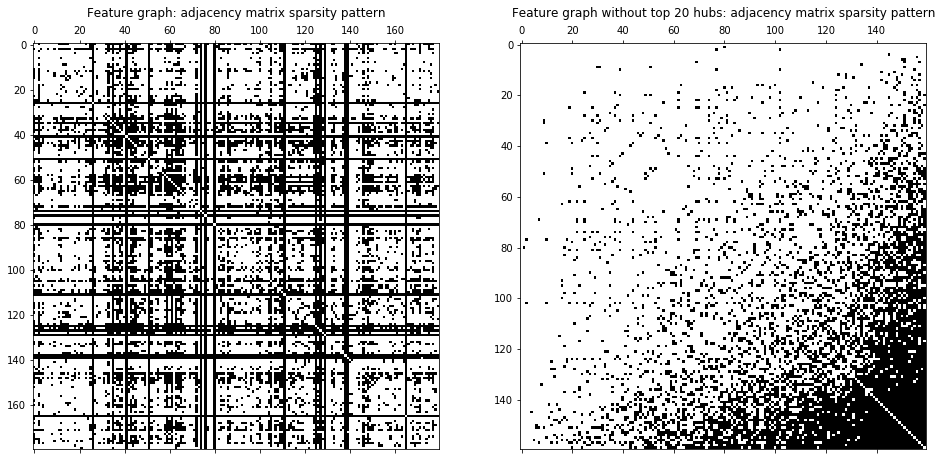

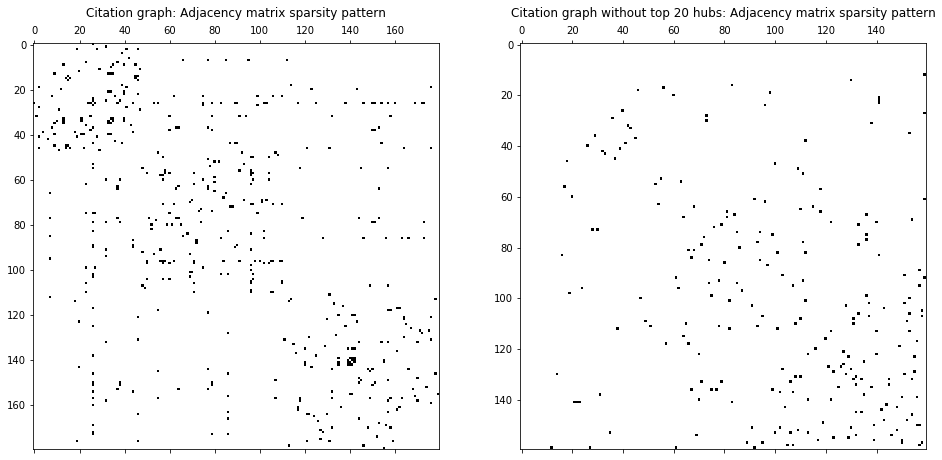

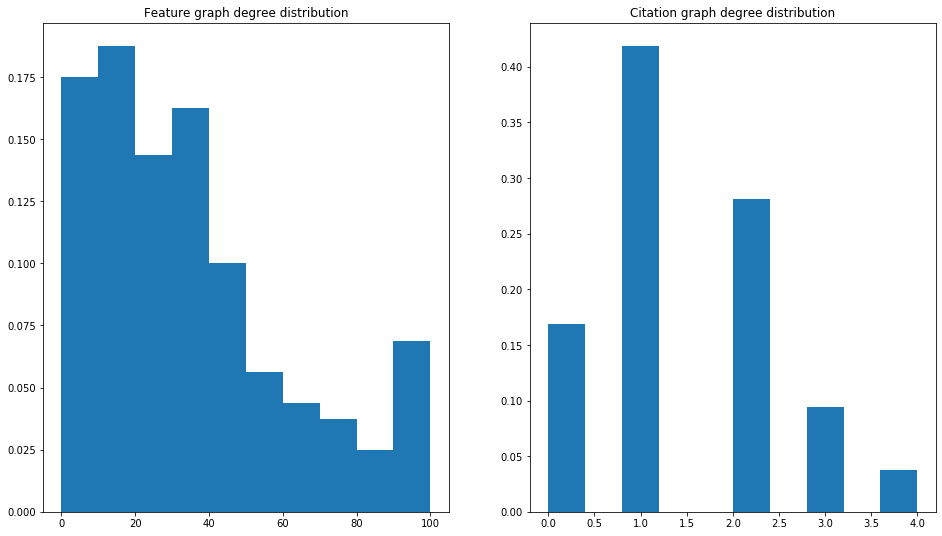

In [35]:
#get degrees of the new unordered one
removed_feat = np.argsort(degrees_feature)[:-20]
removed_cite = np.argsort(degrees_citation)[:-20]

reduced_A_feature = A_feature[removed_feat,:]
reduced_A_feature = reduced_A_feature[:,removed_feat]

reduced_A_citation = A_citation[removed_cite,:]
reduced_A_citation = reduced_A_citation[:, removed_cite]


plt.figure(1, figsize=(16,9))
a=plt.subplot(121)
plt.title('Feature graph: adjacency matrix sparsity pattern')
plt.spy(A_feature)
b=plt.subplot(122)
plt.title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
plt.spy(reduced_A_feature)


plt.figure(2, figsize=(16,9))
a=plt.subplot(121)
plt.title('Citation graph: Adjacency matrix sparsity pattern')
plt.spy(A_citation)
b=plt.subplot(122)
plt.title('Citation graph without top 20 hubs: Adjacency matrix sparsity pattern')
plt.spy(reduced_A_citation)



reduced_degrees_feat = reduced_A_feature.sum(1)
reduced_degrees_cit = reduced_A_citation.sum(1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

plt.figure(3,figsize=(16,9))
plt.subplot(121)
plt.title('Feature graph degree distribution')
plt.hist(reduced_degrees_feat, weights = deg_hist_normalization)
plt.subplot(122)
plt.title('Citation graph degree distribution')
plt.hist(reduced_degrees_cit, weights = deg_hist_normalization)




new_A_citation = reduced_A_citation
new_A_feature = reduced_A_feature 

new_degrees_citation =  reduced_degrees_cit 
new_degrees_feature = reduced_degrees_feat 





Q: Compute the first and second moments for the new graphs.
Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  *Hint: Examine the degree distributions.*

In [36]:
reduced_degfs, reduced_counts_feat = np.unique(reduced_degrees_feat,return_counts=True)
reduced_degns, reduced_counts_net = np.unique(reduced_degrees_cit,return_counts=True)


reduced_degfeatprobs = reduced_counts_feat/reduced_counts_feat.sum()
reduced_degnetprobs = reduced_counts_net/reduced_counts_net.sum()


#Calculate the 1st and 2nd moments of each graph. Explain the differences.


reduced_cit_moment_1 = (reduced_degns*reduced_degnetprobs).sum()
reduced_cit_moment_2 = (reduced_degns*reduced_degns*reduced_degnetprobs).sum()

reduced_feat_moment_1 = (reduced_degfs*reduced_degfeatprobs).sum()
reduced_feat_moment_2 = (reduced_degfs*reduced_degfs*reduced_degfeatprobs).sum()


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

print("Feat graph edges", reduced_A_feature.sum()/2)
print("Citation graph edges", reduced_A_citation.sum()/2)


Citation graph first moment: 1.4124999999999999
Citation graph second moment: 2.9875000000000003
Feature graph first moment:  34.1875
Feature graph second moment:  1870.2124999999999
Feat graph edges 2735.0
Citation graph edges 113.0


**Your answer here:** While the 1st moment is shifted to roughly half of its original value in both cases, the variance of the citation graph seems to be the one most significantly affected. 

Before removing the hubs the highest degree was around 25, with an average degree of 2.833. After removing the hubs the highest degree is around 4 with an average degree 1.412. For the feature graph, the highest degree was around 175 with an average of 64.766. Now the average degree is 34.1875 and the highest degree around 100 with a quite high probability as well. 

The shrinking of the citation graph 2nd moment can be attributed to the fact that its degree distribution is thin-tailed. Thus, the effect of removing hubs becomes more pronounced there. 

### Question: Pruning, sparsity,  paths




Plot the sparsity pattern of the original citation and  feature graphs for your chosen community. 
Why is the feature graph more dense?

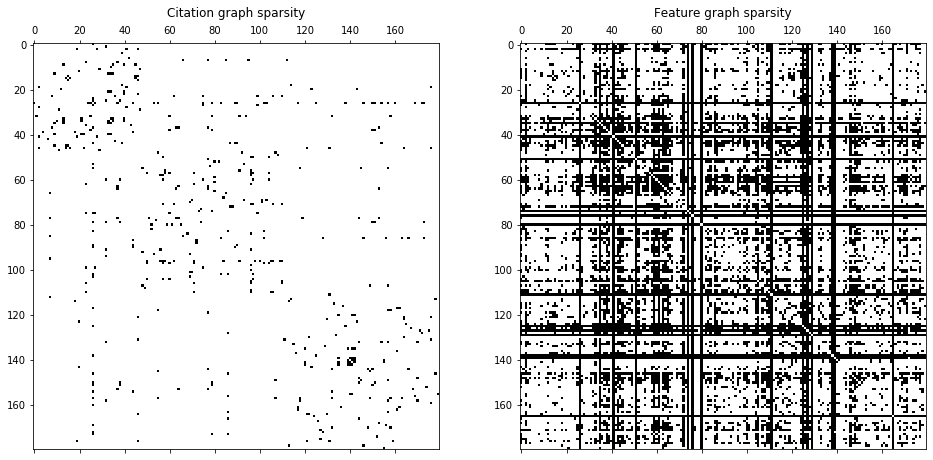

In [37]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title('Citation graph sparsity')
plt.spy(A_citation);
plt.subplot(122)
plt.title('Feature graph sparsity')
plt.spy(A_feature);

**Your answer here:** The feature graph was created by thresholding a euclidean distance matrix using the mean distance as a threshold. Looking at the distribution of pairwise distances and considering the value of the average distance, it is natural to expect that the feature matrix will have more edges as a significant percentage of distances will result in an edge. 

Q: By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.
Check your results by comparing the sparsity patterns and total number of edges between the graphs.



Current threshold:  3.5
Number of edges in the feature graph:  5829.0
Number of edges in the feature graph after pruning:  75.0
Number of edges in the citation graph:  255.0


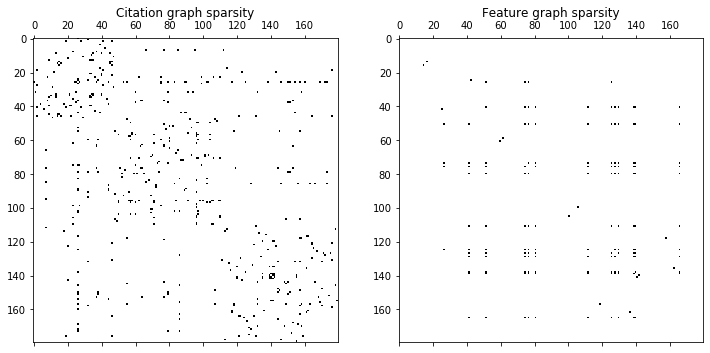

In [38]:
threshold = 3.5

A_feature_pruned = (edm < threshold).astype(float) -np.eye(edm.shape[0])

A_feat_edges = A_feature.sum()/2
A_featpruned_edges = A_feature_pruned .sum()/2  # Your code here.

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Citation graph sparsity')
plt.spy(A_citation);
plt.subplot(122)
plt.title('Feature graph sparsity')
plt.spy(A_feature_pruned);

print("Current threshold: ", threshold)

print("Number of edges in the feature graph: ", (A_feat_edges))
print("Number of edges in the feature graph after pruning: ", (A_featpruned_edges))
print("Number of edges in the citation graph: ", num_edges_citation)

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries:
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j) $

Q: Calculate the path matrices for both the citation and the unpruned feature graphs. 
Examine the sparsity pattern for both of those matrices. [Hint](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers) 

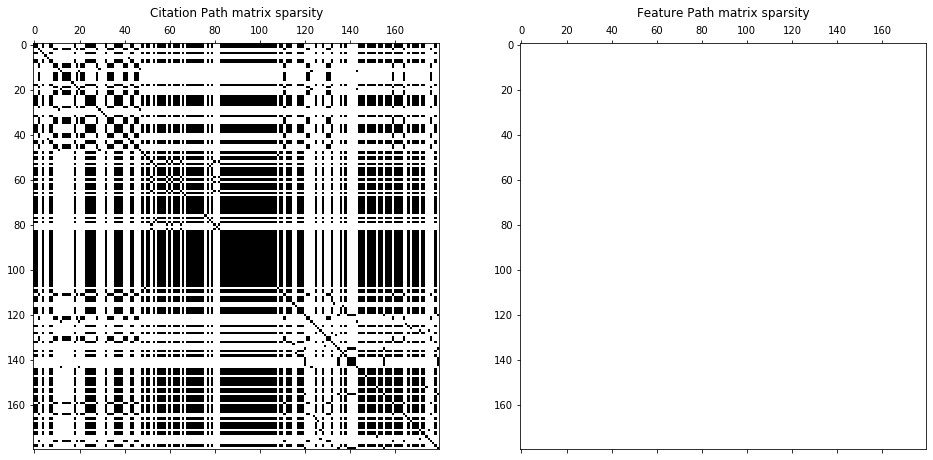

In [39]:
#total number of paths up to length 10 between all pairs of nodes
path_lengths = range(11)


path_matrix_citation = sum([np.linalg.matrix_power(A_citation, k) for k in path_lengths])
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, k) for k in path_lengths]) # Your code here.


plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title('Citation Path matrix sparsity')
plt.spy(path_matrix_citation);
plt.subplot(122)
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_feature);

Q: Now do the same for the pruned graph. Plot the corresponding sparsity pattern. Is there any difference?

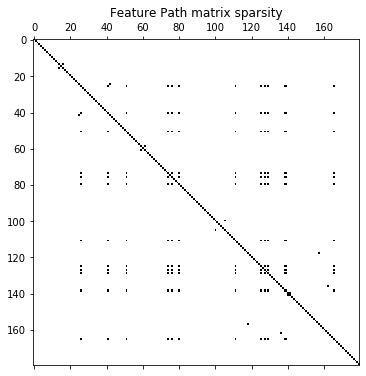

In [40]:
path_matrix_Afeat_pruned = sum([np.linalg.matrix_power(A_feature_pruned, k) for k in path_lengths])

plt.figure(figsize=(12,6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_Afeat_pruned);


**Your answer here:** Yes, the path matrix for the unpruned graph doesn't have zero entries while the one for the pruned graph does.

Q: Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) graph connected?

**Your answer here:** The maximum hop distance between any two nodes in a graph can be on the order of the number of nodes. The [path graph](https://en.wikipedia.org/wiki/Path_graph) is the worst case where one has to traverse all the nodes to get from one endpoint node to the other. By calculating the path matrix for all lengths up to N, where N is the total number of nodes, one expects all the matrix entries to be nonzero, since there will be at least 1 path from all nodes to all other nodes. However, if the graph is not connected, then the path matrix will have zero entries since a subset of nodes will be unreachable by other nodes regardless of the path lengths we consider.
Since the path matrix for the unpruned graph has no zero entries it means that the graph is connected.

Q: If the graph is connected, how can you guess its diameter using the path matrix? If any of your graphs is connected, calculate the diameter using that process. You can check if your guess was correct using [networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.distance_measures.diameter.html).

**Your answer here:** You can guess the diameter by finding the path length k at which the path matrix has no zero entries for the first time. Up until that point there will be an entry (i,j) where no paths from i to j exist because the length of paths considered hasn't reached the diameter.

In [41]:
from networkx import nx
path_matrix = np.zeros((A_feature.shape[0],A_feature.shape[0]))
for k in range(11):
    path_matrix += np.linalg.matrix_power(A_feature, k)
    if (path_matrix==0).sum()==0:
        print("The diameter is: ", k)
        break

    
feature_graph = nx.from_numpy_matrix(A_feature)
print("Diameter according to networkx: ", nx.diameter(feature_graph))
    

The diameter is:  2
Diameter according to networkx:  2


# Section 2 : Network Models

In this section, you will analyze the feature graph and citation graph you constructed in the previous section in terms of the network model types. For this purpose, you can use NetworkX libary imported below.

In [ ]:
import networkx as nx
import warnings
warnings.simplefilter("ignore")

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [ ]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

In [ ]:
G_feature = nx.from_numpy_matrix(A_feature)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

### Question : Simulation with Erdős–Rényi and Barabási–Albert model

Create an Erdős–Rényi and Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation/feature graph.

In [ ]:
n = len(G_citation.nodes())
n

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [ ]:
m = (G_citation.size() + G_feature.size())/2
m

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

In [ ]:
p = # Your code here.
G_er = nx.erdos_renyi_graph(n,p)

Check the number of edges in the Erdős–Rényi graph.

In [ ]:
print('My Erdos-Rényi network to simulate citation graph has {} edges.'.format(G_er.size()))

How do you determine the preferential attachement parameter for Barabási–Albert graphs?

**Your answer here:**

In [ ]:
q = # Your code here.
G_ba = nx.barabasi_albert_graph(n,q)

Check the number of edges in the Barabási–Albert graph.

In [ ]:
print('My Barabási-Albert network to simulate citation graph has {} edges.'.format(G_ba.size()))

### Question :  Giant component

Check the size of the largest connected component in the citation and feature graph.

In [ ]:
giant_citation = # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

In [ ]:
giant_feature = # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

Check the size of the giant components in the generated Erdős–Rényi graph.

In [ ]:
giant_er = # Your code here.
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

Hint: Recall the expected giant component size from the lectures.

In [ ]:
p_new = # Your code here.
G_er_new = nx.erdos_renyi_graph(n,p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network to simulate citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question : Degree Distributions

You already plotted the degree distribution of the citation and feature graph in the first section. Now, plot the degree distribution historgrams for the simulated networks.

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title('Erdos-Rényi network')
er_degrees = # Your code here.
plt.hist(er_degrees);
plt.subplot(132)
plt.title('Barabási-Albert network')
ba_degrees = # Your code here.
plt.hist(ba_degrees);
plt.subplot(133)
plt.title('new Erdos-Rényi network')
er_new_degrees = # Your code here.
plt.hist(er_new_degrees);

In terms of the degree distribution, is there a good match between original citation and feature graph and the simulated networks? For the citation graph, choose one of the simulated networks above that matches its degree distribution at best. Indicate your preference below:

**Your answer here:**

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [ ]:
feature_degrees = # Your code here.
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:**

### Question :  Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [ ]:
nx.average_clustering(G_citation)

In [ ]:
nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

Now, let us check the average clustering coefficient for the simulated networks.

In [ ]:
nx.average_clustering(G_er)

In [ ]:
nx.average_clustering(G_ba)

In [ ]:
nx.average_clustering(nx.Graph(G_config))

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph and the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

If you find other network models, create at most one graph object for the citation and one for feature graph below. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distributions. Comment on the similaries. 

In [ ]:
# Your code here.

**Your answer here:**